# Classical Bayesian optimisation

In [22]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial

In [ ]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

In [40]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [41]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [42]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [43]:
%config InlineBackend.figure_format = "retina"

In [4]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

In [ ]:
key = jax.random.PRNGKey(3141)
key_init_params, key_run = jax.random.split(key)

## Eval experiments

In [152]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ branin

*** Running branin ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
Eval laplace
CPU times: user 15min 45s, sys: 44.5 s, total: 16min 29s
Wall time: 2min 13s


In [153]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ hartmann

*** Running hartmann ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
Eval laplace
CPU times: user 15min 39s, sys: 55.9 s, total: 16min 35s
Wall time: 2min 14s


In [154]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley2

*** Running ackley2 ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
Eval laplace
CPU times: user 15min 52s, sys: 51.1 s, total: 16min 43s
Wall time: 2min 15s


In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley5

*** Running ackley5 ***
Eval VBLL-greedy
Eval VBLL
Eval GP


In [156]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley10

Eval FLoRES
Eval LRKF
Eval LOFI
Eval laplace
CPU times: user 15min 53s, sys: 53.4 s, total: 16min 46s
Wall time: 3min 10s


In [157]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley50

*** Running ackley50 ***
Eval VBLL-greedy
Eval VBLL
Eval GP
Eval FLoRES
Eval LRKF
Eval LOFI
Eval laplace
CPU times: user 15min 57s, sys: 51 s, total: 16min 48s
Wall time: 3min 13s


## Plot results

In [44]:
res_files = !ls *pkl
res_files = res_files

In [45]:
res = {}
for file in res_files:
    if "-res" in file:
        continue
    res_experiment = pd.read_pickle(file)
    res[file.rstrip(".pkl")] = res_experiment

In [46]:
def format_ticks(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))  # 5 major ticks on X-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))  # 4 major ticks on Y-axis
    ax.minorticks_on()    

In [47]:
res.keys()

dict_keys(['ackley10', 'ackley2', 'ackley5', 'ackley50', 'branin', 'hartmann', 'nndraw10', 'nndraw200', 'nndraw50'])

In [48]:
experiments_names = ["ackley2", "ackley5", "ackley10", "ackley50", "branin", "hartmann", "nndraw50", "nndraw200"]

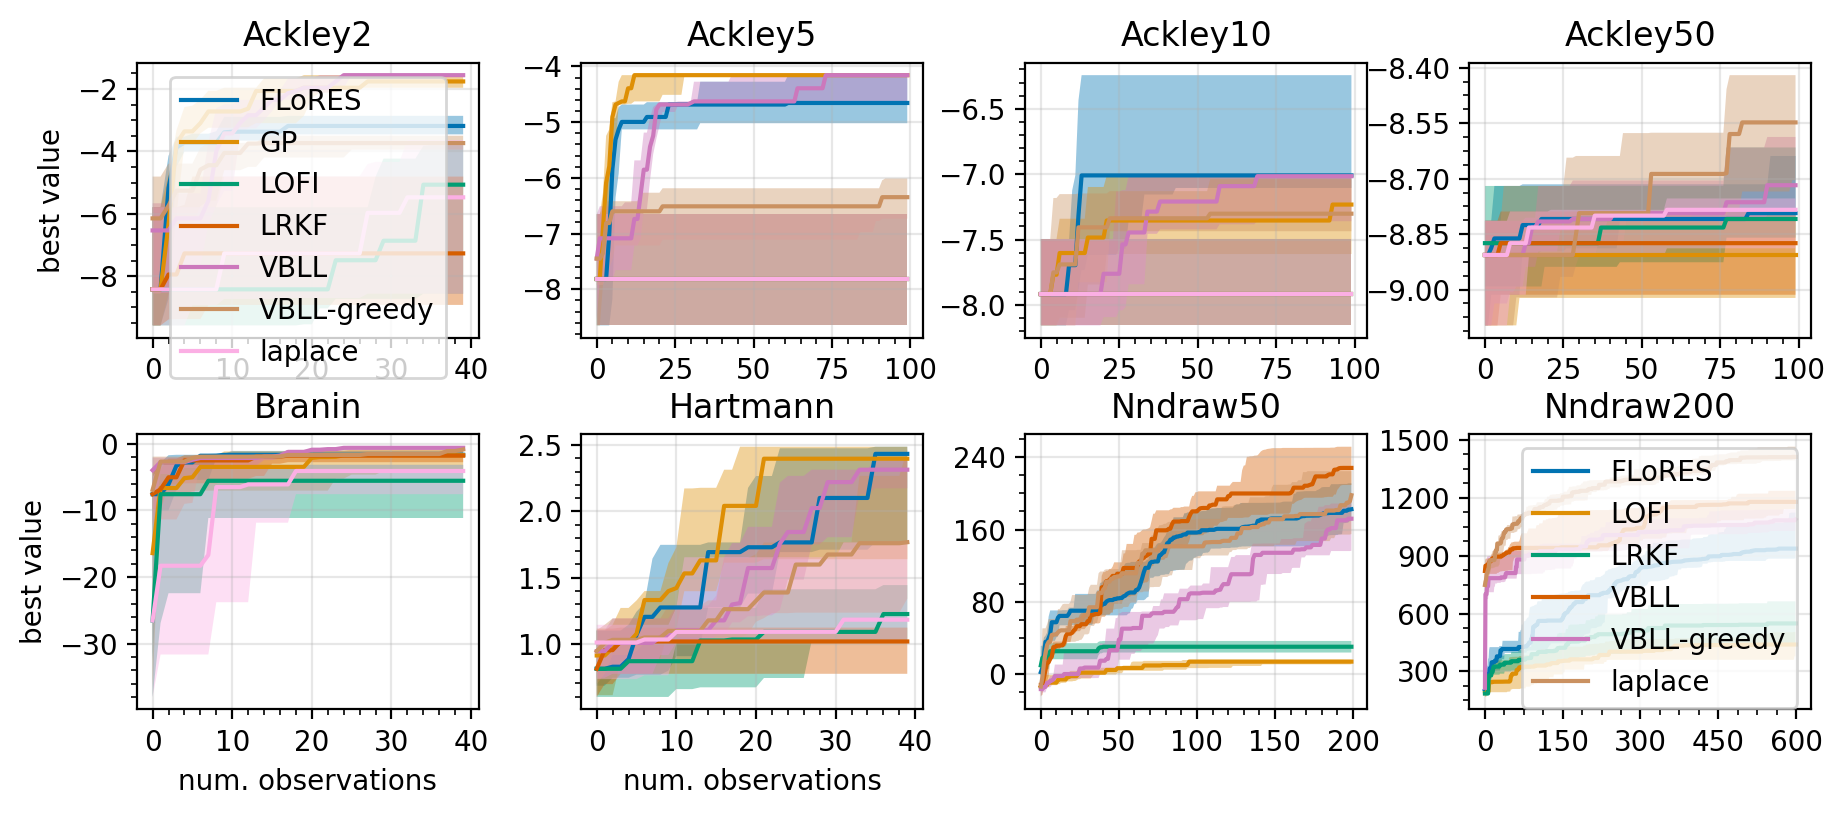

In [49]:
fig, axs = plt.subplots(2, 4, figsize=(7.2 * 1.5, 4.2))
methods = sorted(list(res["ackley2"]))

for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]
        plot_hist(ax, runs["y_best"], label=name_method)
    format_ticks(ax)
    ax.set_title(name.capitalize())
    ax.grid(alpha=0.3)
# axs[0,0].legend(ncol=7, bbox_to_anchor=(2.3, 1.4), frameon=False, handlelength=1)
axs[0,0].legend()
axs[-1,-1].legend()

axs[1,0].set_xlabel("num. observations")
axs[1,1].set_xlabel("num. observations")
axs[0,0].set_ylabel("best value")
axs[1,0].set_ylabel("best value")
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.savefig("../figures/bayesopt-iterations.png", dpi=300, bbox_inches="tight")

In [50]:
summary = []
for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]

        summary.append({
            "y_best": runs["y_best"][:, -1].mean(),
            "y_best_std": runs["y_best"][:, -1].std(),
            "time": runs["time"],
            "method": name_method,
            "experiment": name
        })
summary =pd.DataFrame(summary)

summary["time"] = summary["time"].astype(float)

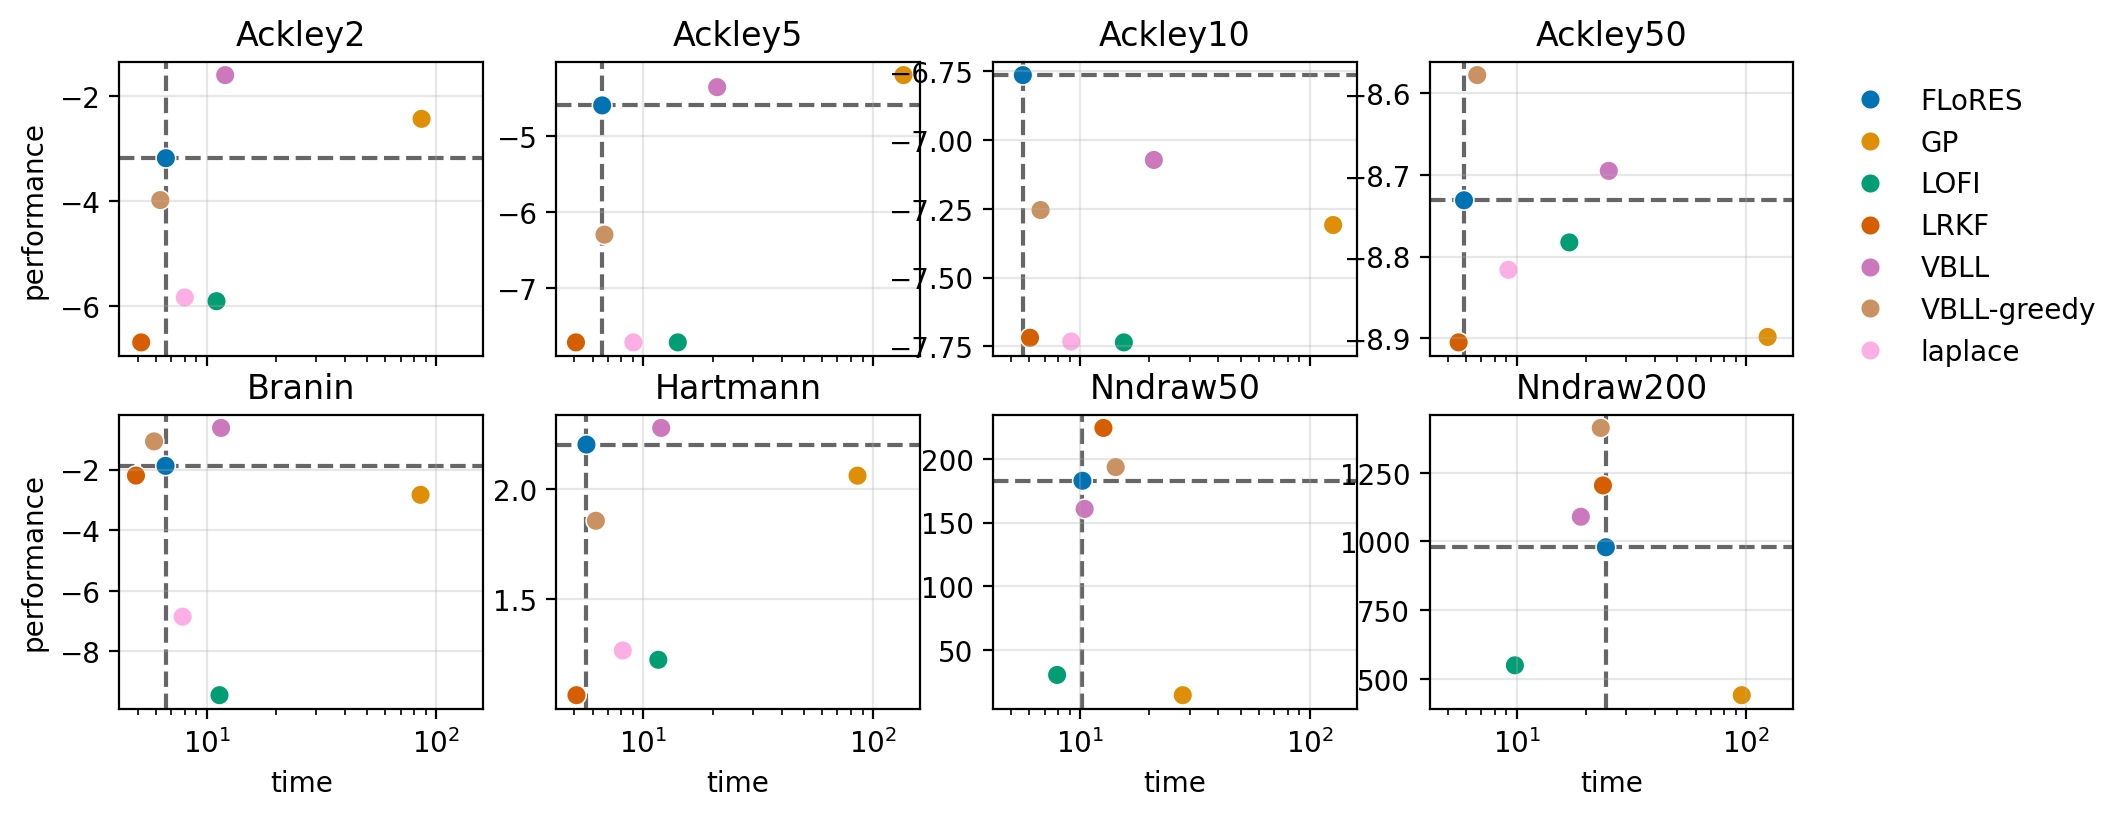

In [51]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(7.2 * 1.5, 4.2))

experiments = summary["experiment"].unique()
for ax, experiment in zip(axs.ravel(), experiments_names):
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=summary.query("experiment == @experiment"),
        ax=ax,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.set_title(experiment.capitalize())
    ax.grid(alpha=0.3)
    ax.set_ylabel("")
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    plt.grid(alpha=0.3)
axs[0,0].set_ylabel("performance")
axs[1,0].set_ylabel("performance")
axs[0,3].legend(loc="upper right", bbox_to_anchor=(1.9, 1.0), frameon=False)
# axs[0,0].legend()
plt.savefig("../figures/bayesopt-time-performance.png", dpi=300, bbox_inches="tight")

In [52]:
summary.pivot_table(index="method", columns="experiment")["y_best"]

experiment,ackley10,ackley2,ackley5,ackley50,branin,hartmann,nndraw200,nndraw50
method,,,,,,,,
FLoRES,-6.763535,-3.181227,-4.602024,-8.731215,-1.880822,2.199012,979.010925,182.848419
GP,-7.308882,-2.432426,-4.204634,-8.898325,-2.835982,2.058608,NaN,NaN
LOFI,-7.735974,-5.906063,-7.710509,-8.782741,-9.449255,1.227836,439.669495,14.275783
LRKF,-7.719150,-6.690907,-7.710509,-8.904983,-2.200639,1.068193,548.546326,30.191509
VBLL,-7.072278,-1.598789,-4.362828,-8.695254,-0.626927,2.274089,1204.465088,224.407562
VBLL-greedy,-7.254537,-3.979560,-6.297515,-8.578159,-1.071544,1.855081,1090.224731,160.695618
laplace,-7.732709,-5.834692,-7.710509,-8.816259,-6.857860,1.269688,1414.116699,193.585800


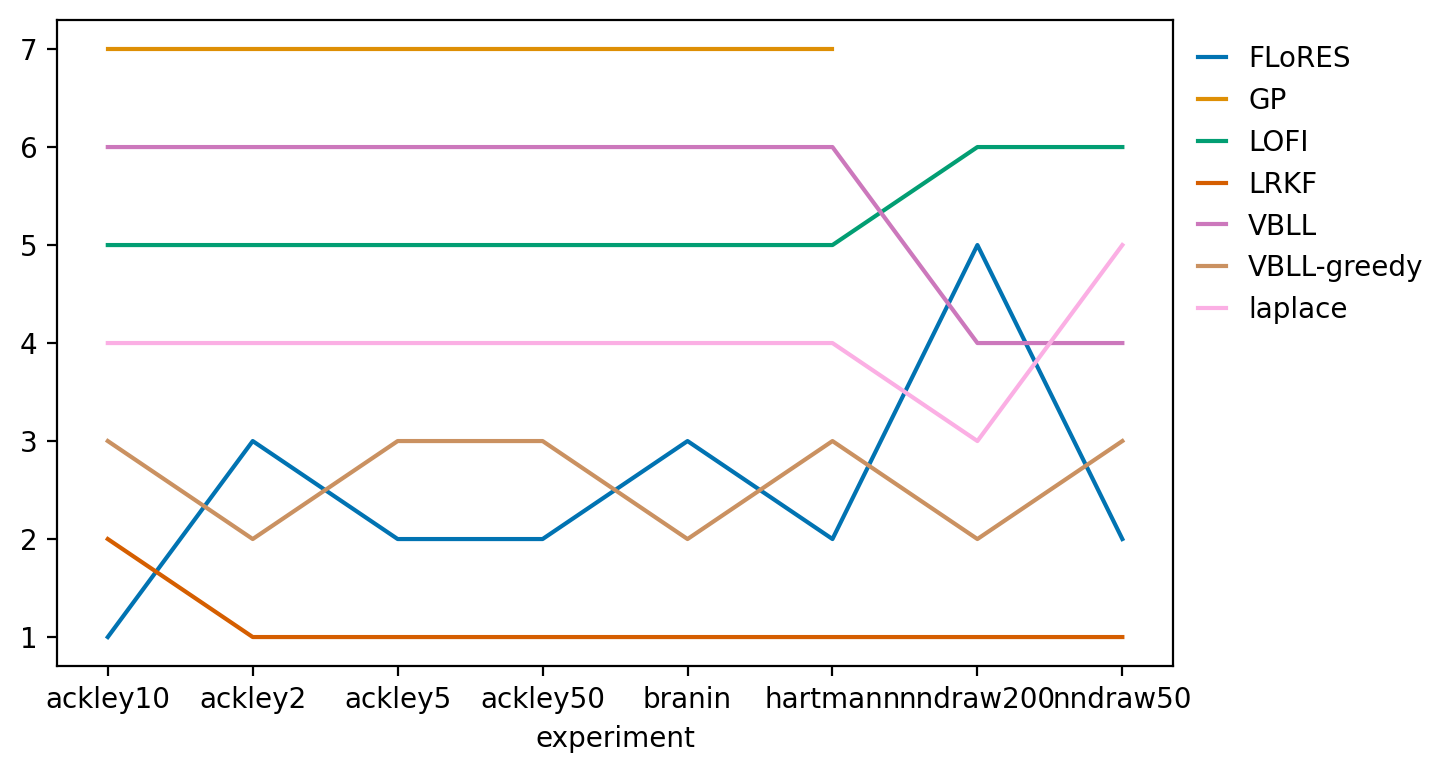

In [53]:
rank_time = summary.pivot_table(index="method", columns="experiment")["time"].rank(axis=0)
rank_time.T.plot()
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

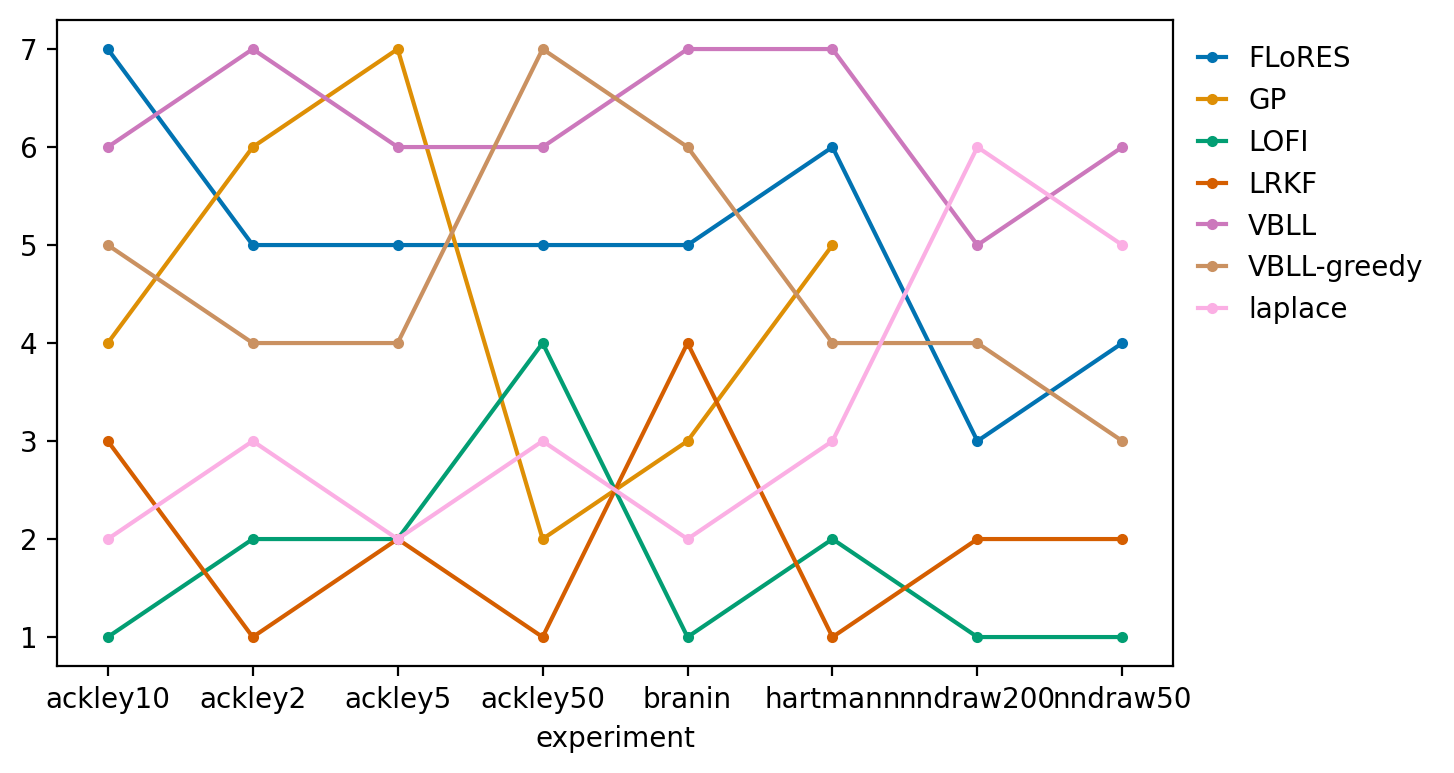

In [54]:
rank_ybest = summary.pivot_table(index="method", columns="experiment")["y_best"].rank(axis=0)
rank_ybest.T.plot(marker="o", markersize=3)
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

In [55]:
rank_time_melt = rank_time.reset_index().melt("method").rename({"value": "time"}, axis=1)
rank_ybest_melt = rank_ybest.reset_index().melt("method").rename({"value": "ybest"}, axis=1)

In [56]:
rank_melt = pd.merge(rank_time_melt, rank_ybest_melt, on=["method", "experiment"])

In [57]:
mean_ranks = (
    rank_melt.groupby("method")[["time", "ybest"]].agg(["mean", "std"])
)

mean_ranks = mean_ranks.rename({"median": "mean"}, axis=1, level=1)

In [58]:
mean_ranks

time            ybest          
              mean       std   mean       std
method                                       
FLoRES       2.500  1.195229  5.000  1.195229
GP           7.000  0.000000  4.500  1.870829
LOFI         5.250  0.462910  1.750  1.035098
LRKF         1.125  0.353553  2.000  1.069045
VBLL         5.500  0.925820  6.250  0.707107
VBLL-greedy  2.625  0.517549  4.625  1.302470
laplace      4.000  0.534522  3.250  1.488048

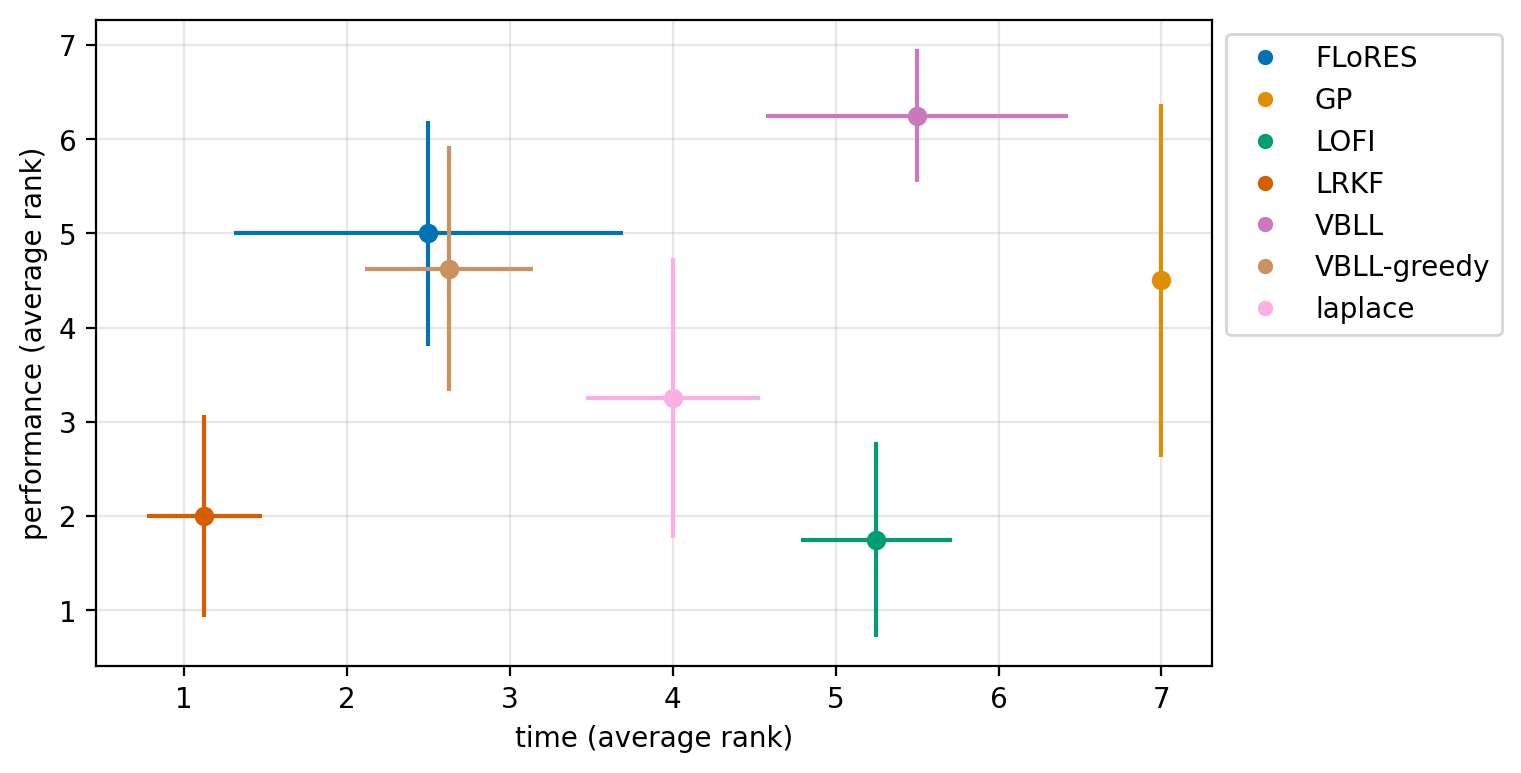

In [59]:
for method in methods:
    plt.errorbar(
        x=mean_ranks.xs("mean", axis=1, level=1)["time"][method],
        y=mean_ranks.xs("mean", axis=1, level=1)["ybest"][method],
        fmt="o",
        yerr=mean_ranks.xs("std", axis=1, level=1)["ybest"][method],
        xerr=mean_ranks.xs("std", axis=1, level=1)["time"][method],
    )
sns.scatterplot(
    x="time",
    y="ybest",
    hue="method",
    data=mean_ranks.xs("mean", axis=1, level=1).reset_index(),
)

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("time (average rank)")
plt.ylabel("performance (average rank)")
plt.grid(alpha=0.3);
plt.savefig("../figures/bayesopt-time-performance-scatter.png", dpi=300, bbox_inches="tight")

## Ackley 1d: Gaussian process with Matern Kernel

In [348]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=-4, ubound=5)
x_test = jnp.zeros(1)
dim = len(x_test)

In [349]:
key = jax.random.PRNGKey(314)
x = jax.random.uniform(key, minval=0, maxval=1, shape=(10,))[:, None]
y = jax.vmap(objective_fn)(x)

In [343]:
x_test = jnp.linspace(0, 1, 500)[:, None]
y_test = jax.vmap(objective_fn)(x_test)

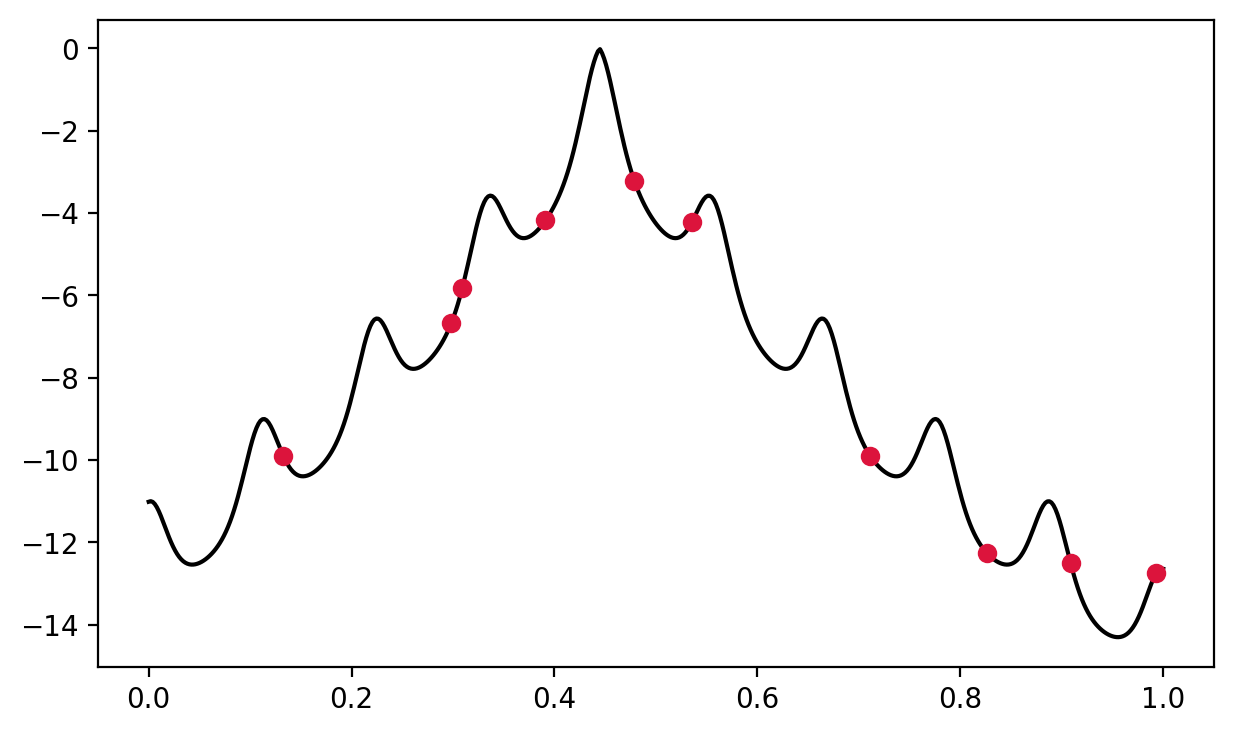

In [344]:
plt.scatter(x, y, c="crimson")
plt.plot(x_test, y_test, c="black", zorder=0)

## Bayesopt

In [64]:
from rebayes_mini.methods import gaussian_process as gp

In [65]:
keys = jax.random.split(key, 20)

In [66]:
kernel = gp.matern_kernel(length_scale=0.1, nu=5/2)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)

In [67]:
bel, _ = agent.scan(bel_init, y, x)

In [68]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x) 

y_samples = eval_fn(keys, bel, x_test).squeeze()

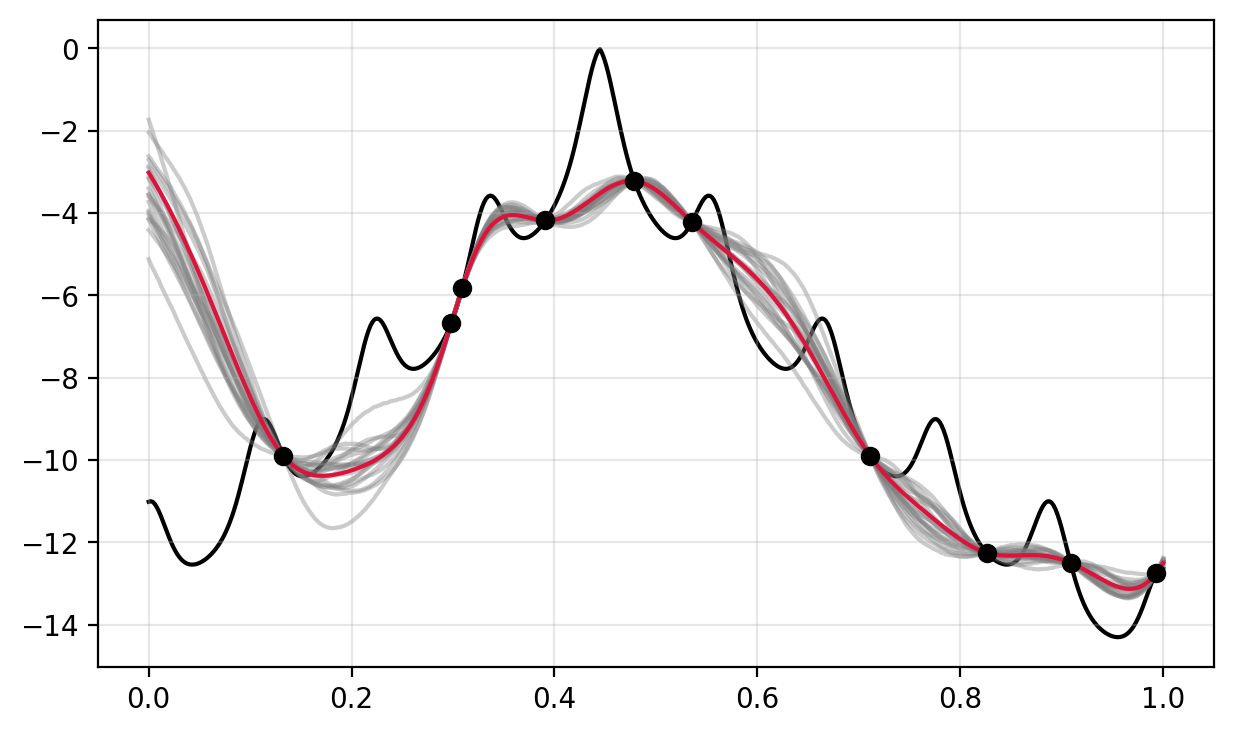

In [69]:
plt.plot(x_test, y_test, c="black", zorder=0)
plt.plot(x_test, agent.mean_fn(bel, x_test), c="crimson")
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.4, zorder=0);

In [70]:
bel_update = agent.update(bel_init, y[0], x[0])

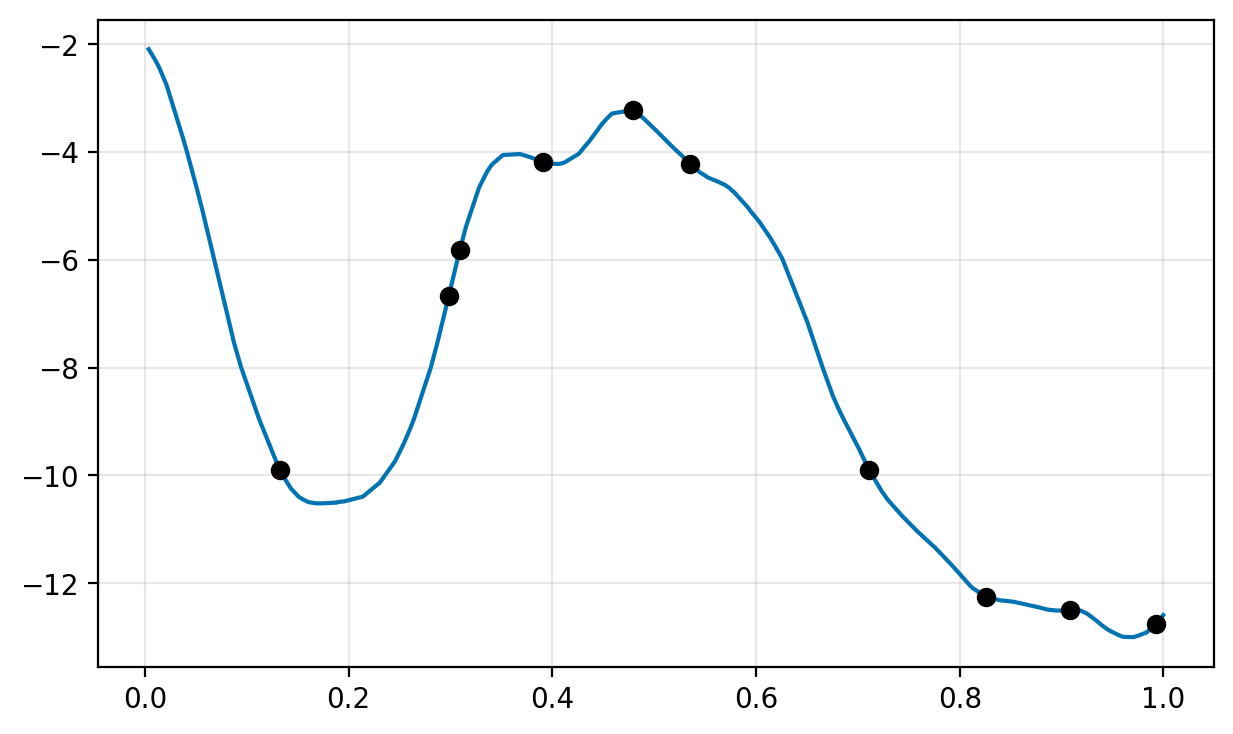

In [71]:
n_eval = 200
x_eval = jnp.sort(jax.random.uniform(key, minval=0, maxval=1, shape=(n_eval, 1)), axis=0)

fn = agent.sample_fn(key, bel)
y_eval = fn(x_eval)

plt.plot(x_eval, y_eval)
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)

# VBLL

In [72]:
import optax
from rebayes_mini.methods import replay_sgd
from flax.training.train_state import TrainState
from vbll_fifo import Regression, FifoVBLL

In [73]:
class VBLLMLP(nn.Module):
    n_hidden: int = 180

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / 10.0,
        )(x)
        return x

In [74]:
vbll = VBLLMLP()
params_init = vbll.init(key_init_params, x_test[:, None])

In [75]:
def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

In [86]:
%%time
agent = FifoVBLL(
    vbll.apply,
    lossfn,
    tx=optax.adamw(1e-3),
    buffer_size=10,
    dim_features=1,
    dim_output=1,
    n_inner=10_000
)

bel_init = agent.init_bel(params_init)
bel_final, _ = agent.scan(bel_init, y, x)
bel_final = jax.block_until_ready(bel_final)

CPU times: user 2.24 s, sys: 61.3 ms, total: 2.3 s
Wall time: 8.47 s


In [87]:
fn = agent.sample_fn(key_run, bel_final)
ysampled = fn(x_test)

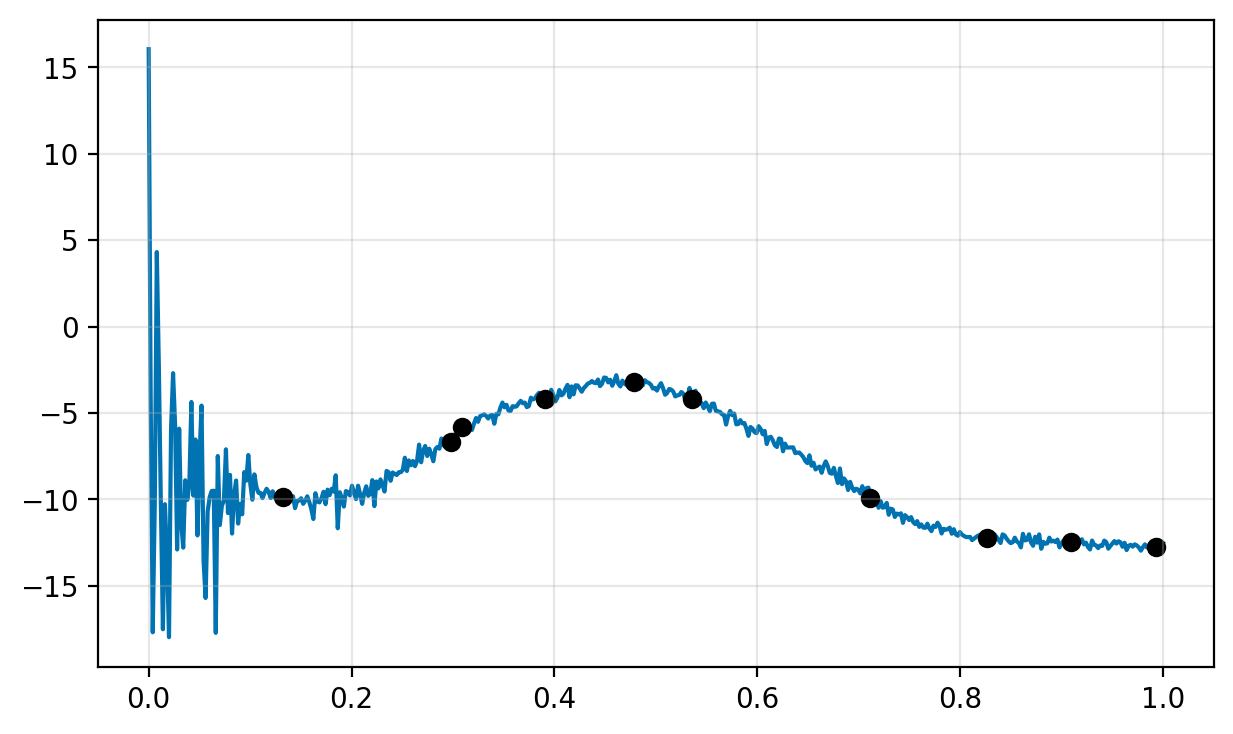

In [90]:
plt.plot(x_test, ysampled, zorder=0)
plt.scatter(x, y, c="black")
plt.grid(alpha=0.3)

In [89]:
mean = agent.mean_fn(bel_final, x_test)
sigma = jnp.sqrt(agent.cov_fn(bel_final, x_test))

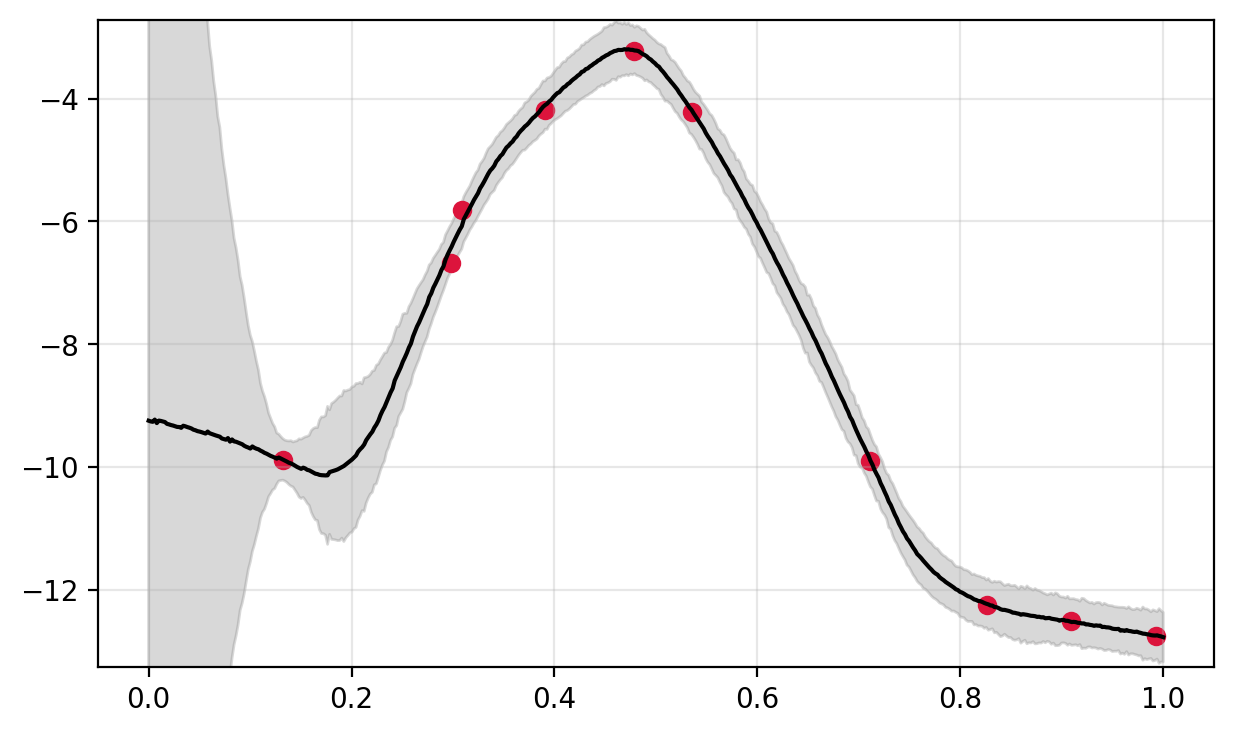

In [91]:
lbound = mean - 2 * sigma
ubound = mean + 2 * sigma

plt.plot(x_test.ravel(), mean, c="black")
ymin, ymax = plt.ylim()
plt.fill_between(x_test.ravel(), lbound, ubound, color="tab:gray", alpha=0.3)
plt.scatter(x, y, c="crimson")
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

## Simple test

In [32]:
x_test = jnp.linspace(0, 1.2, 200)[:, None]
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])[:, None]
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])

In [33]:
kernel = gp.gaussian_kernel(sigma2=0.01)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)
bel, _ = agent.scan(bel_init, y, x)

In [34]:
keys = jax.random.split(key, 20)

In [35]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x)

In [36]:
y_samples = eval_fn(keys, bel, x_test).squeeze()

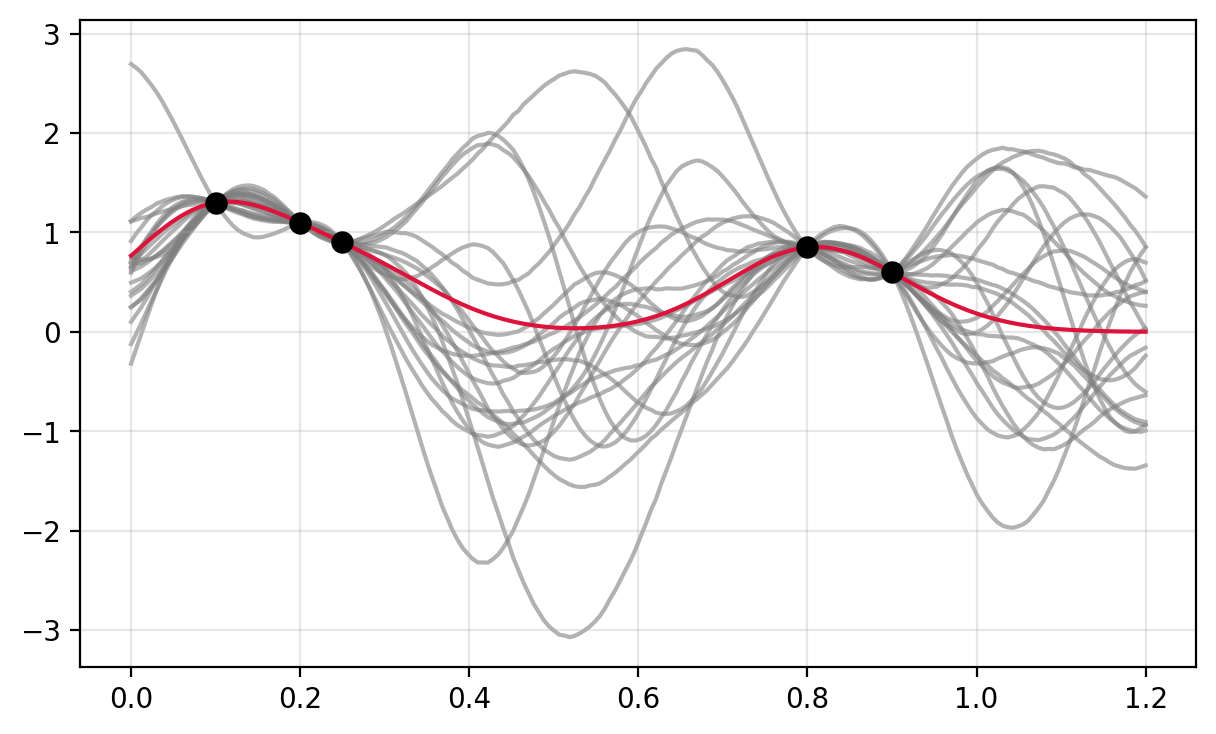

In [37]:
yhat = agent.mean_fn(bel, x_test)
plt.scatter(x, y, c="black", s=50, zorder=3)
plt.plot(x_test, yhat, c="crimson")
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.6, zorder=0)
plt.grid(alpha=0.3)